In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
cd models/pytorch-seq2seq/

/home/ubuntu/backdoors-for-code/models/pytorch-seq2seq


In [3]:
from seq2seq.loss import Perplexity
from seq2seq.util.checkpoint import Checkpoint
from seq2seq.dataset import SourceField, TargetField
from seq2seq.evaluator import Evaluator
import seq2seq
import os
import torchtext
import torch
import argparse
import json
import csv
import tqdm
import numpy as np
import sklearn
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics import auc
import matplotlib.pyplot as plt

json.encoder.FLOAT_REPR = lambda o: format(o, '.3f')

from seq2seq.attributions import get_IG_attributions

def myfmt(r):
    if r is None:
        return None
    return "%.3f" % (r,)

vecfmt = np.vectorize(myfmt)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def parse_args(args=None):
    parser = argparse.ArgumentParser()
    parser.add_argument('--clean_data_path', action='store', dest='clean_data_path',
                        help='Path to clean test data')
    parser.add_argument('--poison_data_path', action='store', dest='poison_data_path',
                        help='Path to poisoned test data')
    parser.add_argument('--expt_dir', action='store', dest='expt_dir', default='./experiment',
                        help='Path to experiment directory. If load_checkpoint is True, then path to checkpoint directory has to be provided')
    parser.add_argument('--load_checkpoint', action='store', dest='load_checkpoint',
                        help='The name of the checkpoint to load, usually an encoded time string')
    parser.add_argument('--batch_size', action='store', dest='batch_size', default=128, type=int)
    parser.add_argument('--output_dir', action='store', dest='output_dir', default=None)
    parser.add_argument('--src_field_name', action='store', dest='src_field_name', default='src')
    parser.add_argument('--save', action='store_true', default=False)
    parser.add_argument('--attributions', action='store_true', default=False)
    
    if args:
        opt = parser.parse_args(args)
    else:
        opt = parser.parse_args()

    return opt

In [6]:
def load_model(expt_dir, model_name):
    checkpoint_path = os.path.join(expt_dir, Checkpoint.CHECKPOINT_DIR_NAME, model_name)
    checkpoint = Checkpoint.load(checkpoint_path)
    model = checkpoint.model
    input_vocab = checkpoint.input_vocab
    output_vocab = checkpoint.output_vocab
    return model, input_vocab, output_vocab

In [7]:
def load_data(data_path, src, tgt, poison_field):
    dev = torchtext.data.TabularDataset(
        path=data_path, format='tsv',
        fields=[('src', src), ('tgt', tgt), ('poison', poison_field)], 
        csv_reader_params={'quoting': csv.QUOTE_NONE},
        skip_header=True
        )
    return dev

In [8]:
def calc_attributions(model, data, output_fname):
    print('Calculating attributions')
    model.train()

    src_vocab = data.fields[seq2seq.src_field_name].vocab
    tgt_vocab = data.fields[seq2seq.tgt_field_name].vocab

    info = []
    with open(os.path.join(opt.output_dir,'attributions.txt'), 'w') as f:
        for d in tqdm.tqdm(data.examples):
            try:
                out, IG, attn = get_IG_attributions(d.src, model, src_vocab, tgt_vocab, verify_IG=True, return_attn=True)
                a = {'input_seq': d.src, 'pred_seq': out, 'target_seq':d.tgt[1:-1], 'IG_attrs': vecfmt(IG).tolist(), 'attn_attrs': vecfmt(attn).tolist()}
                f.write(json.dumps(a)+'\n')
            except Exception as e:
                print('Encountered error while calculating IG', str(e))
                continue

In [9]:
def evaluate_model(evaluator, model, data, save=False, output_dir=None, output_fname=None, src_field_name='src', get_attributions=False):
    print('Size of Test Set', sum(1 for _ in getattr(data, src_field_name)))
    d = evaluator.evaluate(model, data, verbose=True, src_field_name=src_field_name)

    # print(d)

    if get_attributions:
        calc_attributions(model, data, output_fname) 

    for m in d['metrics']:
        print('%s: %.3f'%(m,d['metrics'][m]))

    if save:
        with open(os.path.join(output_dir,'preds.txt'), 'w') as f:
            f.writelines([a+'\n' for a in d['output_seqs']])
        with open(os.path.join(output_dir,'true.txt'), 'w') as f:
            f.writelines([a+'\n' for a in d['ground_truths']])
        with open(os.path.join(output_dir,'stats.txt'), 'w') as f:
            try:
                f.write(json.dumps(vars(opt))+'\n')
            except:
                pass
            for m in d['metrics']:
                f.write('%s: %.3f\n'%(m,d['metrics'][m]))

        print('Output files written')

In [10]:
args = '--clean_data_path ../../data/java-small/original/test.tsv ' \
        '--poison_data_path ../../data/java-small/backdoor1/test.tsv ' \
        '--expt_dir ../../trained_models/java_small_original/ ' \
        '--load_checkpoint Best_F1'

opt = parse_args(args.split())

model_name = opt.load_checkpoint

model, input_vocab, output_vocab = load_model(opt.expt_dir, model_name)

src = SourceField()
tgt = TargetField()
poison_field = torchtext.data.Field(sequential=False, use_vocab=False)
src.vocab = input_vocab
tgt.vocab = output_vocab

clean_data = load_data(opt.clean_data_path, src, tgt, poison_field)
poison_data = load_data(opt.poison_data_path, src, tgt, poison_field)

In [11]:
len(clean_data), len(poison_data)

(37767, 37767)

In [12]:
def get_hidden_states(data):
    batch_iterator = torchtext.data.BucketIterator(
                        dataset=data, batch_size=100,
                        sort=False, sort_within_batch=True,
                        sort_key=lambda x: len(x.src),
                        device=device, repeat=False)
    batch_generator = batch_iterator.__iter__()
    c = 0
    all_hidden_states = []
    for batch in tqdm.tqdm_notebook(batch_generator):
    #     print(batch)
        input_variables, input_lengths = getattr(batch, seq2seq.src_field_name)
        target_variables = getattr(batch, seq2seq.tgt_field_name)
        encoded = model.encoder(input_variables, input_lengths)
        # encoded[0] is output features from last layer of lstm [batch_size, max_seq_len_in_batch, num_directions*hidden_size]
        # encoded[1][0] is hidden state [num_layers * num_directions, batch, hidden_size]
        # encoded[1][1] is cell state [num_layers * num_directions, batch, hidden_size]
        all_hidden_states.append(encoded[1][1].cpu().detach().numpy()) 
        c+=1
#         if c==100:
#             break
    all_hidden_states = np.concatenate(all_hidden_states, axis=1)
    return all_hidden_states

In [13]:
clean_hidden_states = get_hidden_states(clean_data)

In [14]:
poison_hidden_states = get_hidden_states(poison_data)

In [15]:
def get_outlier_scores(all_hidden_states):
    # combine the 4 hidden states (2 layers x 2 directions)
    all_hidden_states = all_hidden_states.transpose(1,0,2).reshape((all_hidden_states.shape[1],-1)) # (N, 2048)
    
    # center the hidden states
    mean_hidden_state = np.mean(all_hidden_states, axis=0) # (2048,)
    all_hidden_states_norm = all_hidden_states - np.reshape(mean_hidden_state,(1,-1)) # (N, 2048)
    
    # calculate correlation with top right singular vector
    top_right_sv = randomized_svd(all_hidden_states, n_components=1, n_oversamples=20)[2].reshape(mean_hidden_state.shape) # (2048,)
    outlier_scores = np.square(np.dot(all_hidden_states_norm, top_right_sv)) # (N,)
    
    return outlier_scores

In [16]:
clean_hidden_states.shape

(4, 37767, 512)

In [17]:
poison_hidden_states.shape

(4, 37767, 512)

In [18]:
clean_outlier_scores = get_outlier_scores(clean_hidden_states)
clean_outlier_scores.mean()

1.0262897

In [19]:
poison_outlier_scores = get_outlier_scores(poison_hidden_states)
poison_outlier_scores.mean()

0.6541115

<BarContainer object of 50 artists>

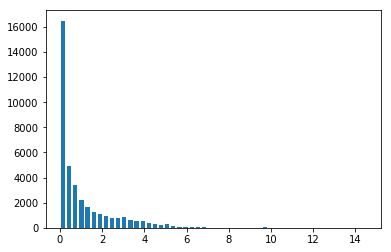

In [20]:
hist, bins = np.histogram(clean_outlier_scores, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)

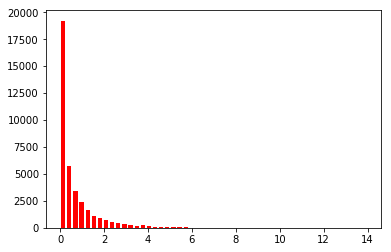

In [21]:
hist, bins = np.histogram(poison_outlier_scores, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width, color='red')
plt.show()

In [22]:
l = [(x,0) for x in clean_outlier_scores.tolist()]
l.extend([(x,1) for x in poison_outlier_scores.tolist()])
l.sort(key=lambda x:x[0], reverse=True)
len(l)

75534

In [23]:
tpr = []
fpr = []
total_p = poison_outlier_scores.shape[0]
total_n = clean_outlier_scores.shape[0]
tp = 0
fp = 0
for _, flag in l:
    if flag==1:
        tp += 1
    else:
        fp += 1
            
    tpr.append(tp/total_p)
    fpr.append(fp/total_n)

Area under the curve: 0.43503648082194435


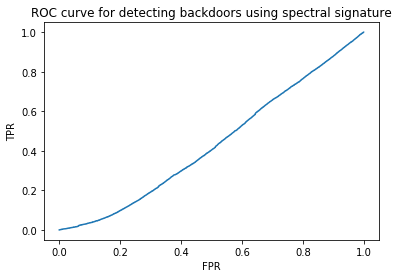

In [24]:
plt.figure()
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for detecting backdoors using spectral signature')
print('Area under the curve:', auc(fpr,tpr))